# Electromagnetics example

Theoretical introduction by: Hans Petter Langtangen and Anders Logg

Implementation by: Jørgen S. Dokken

In this example, we will consider an iron cylinder with copper wires wound around the cylinder, as shown below

![Cross section of wires](wire.png)

Through the copper wires a static current of $J=1A$ is flowing.
We would like to compute the magnetic field $B$ in the iron cylinder, the copper wires, and the surrounding vaccum.

We start by simplifying the problem to a 2D problem. We can do this by assuming that the cylinder extends far along the z-axis and as a consequence the field is virtually independent of the z-coordinate.
Next, we consider Maxwell's equation to derive a Poisson equation for the magnetic field (or rather its potential)

$$
\nabla \cdot D = \rho,
$$
$$
\nabla \cdot B = 0,
$$
$$
\nabla \times E = -\frac{\partial B}{\partial t},
$$
$$
\nabla \times H = \frac{\partial D}{\partial t}+ J.
$$

Here, $D$ is the displacement field, $B$ is the magnetic field, $E$ is the electric field, and $H$ is the magnetizing field.
In addition to Maxwell's equation, we need a constitutive relation between $B$ and $H$,

$$
B =\mu H,
$$

which holds for an isotropic linear magnetic medium.
Here, $\mu$ is the magnetic permability of the material.
Now, since $B$ is solenodial (divergence free) accoording to Maxwell's equations, we known that $B$ must be the curl of some vector field $A$. This field is called the magnetic vector potential. Since the problem is static and thus $\frac{\partial D}{\partial t}=0$, it follows that

$$
J = \nabla \times H = \nabla \times(\mu^{-1} B)=\nabla \times (\mu^{-1}\nabla \times A ) = -\nabla \cdot (\mu^{-1}\nabla A).
$$

In the last step, we have expanded the second derivatives and used the gauge freedom of $A$ to simplify the equations to a simple vector-valued Poisson equation for the magnetic vector potential; if $B=\nabla \times A$, then $B=\nabla \times (A+\nabla \phi)$ for any scalar field $\phi$ (the gauge function).
For the current problem, we thus need to solve the following 2D Poisson problem for the $z$-component $A_z$ of the magnetic vector potential

$$
    - \nabla \cdot (\mu^{-1} \nabla A_z) = J_z \qquad \text{in } \mathbb{R}^2,\\
$$
$$
\lim_{\vert(x,y)\vert\to \infty}A_z = 0.
$$

Since we cannot solve the problem on an infinite domain, we will truncate the domain using a large disk, and set $A_z=0$ on the boundary. The current $J_z$ is set to $+1$A in the interior set of the circles (copper-wire cross sections) and to $-1$ A in the exterior set of circles in the cross section figure.
Once the magnetic field vector potential has been computed, we can compute the magnetic field $B=B(x,y)$ by

$$
    B(x,y)=\left(\frac{\partial A_z}{\partial y}, - \frac{\partial A_z}{\partial x} \right).
$$

The weak formulation is easily obtained by multiplication of a test function $v$, followed by integration by parts, where all boundary integrals vanish due to the Dirichlet condition, we obtain $a(A_z,v)=L(v)$ with

$$
a(A_z, v)=\int_\Omega \mu^{-1}\nabla A_z \cdot \nabla v ~\mathrm{d}x,
$$
$$
L(v)=\int_\Omega J_z v~\mathrm{d} x.
$$

## Meshing a complex structure with subdomains

We create the domain visualized in the cross section figure above using gmsh. Note that we are using the `gmsh.model.occ.fragment` commands to ensure that the boundaries of the wires are resolved in the mesh.

In [1]:
from dolfinx import default_scalar_type
from dolfinx.fem import (dirichletbc, Expression, Function, functionspace, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.io.gmshio import model_to_mesh
from dolfinx.mesh import compute_midpoints, locate_entities_boundary
from dolfinx.plot import vtk_mesh

from ufl import TestFunction, TrialFunction, as_vector, dot, dx, grad
from mpi4py import MPI

import gmsh
import numpy as np
import pyvista

rank = MPI.COMM_WORLD.rank

gmsh.initialize()
r = 0.1   # Radius of copper wires
R = 5     # Radius of domain
a = 1     # Radius of inner iron cylinder
b = 1.2   # Radius of outer iron cylinder
N = 8     # Number of windings
c_1 = 0.8  # Radius of inner copper wires
c_2 = 1.4  # Radius of outer copper wires
gdim = 2  # Geometric dimension of the mesh
model_rank = 0
mesh_comm = MPI.COMM_WORLD
if mesh_comm.rank == model_rank:

    # Define geometry for iron cylinder
    outer_iron = gmsh.model.occ.addCircle(0, 0, 0, b)
    inner_iron = gmsh.model.occ.addCircle(0, 0, 0, a)
    gmsh.model.occ.addCurveLoop([outer_iron], 5)
    gmsh.model.occ.addCurveLoop([inner_iron], 6)
    iron = gmsh.model.occ.addPlaneSurface([5, 6])
    gmsh.model.occ.synchronize()

    # Define geometry for background
    background = gmsh.model.occ.addDisk(0, 0, 0, R, R)
    gmsh.model.occ.synchronize()

    # Define the copper-wires inside iron cylinder
    angles_N = [i * 2 * np.pi / N for i in range(N)]
    wires_N = [(2, gmsh.model.occ.addDisk(c_1 * np.cos(v), c_1 * np.sin(v), 0, r, r)) for v in angles_N]

    # Define the copper-wires outside the iron cylinder
    angles_S = [(i + 0.5) * 2 * np.pi / N for i in range(N)]
    wires_S = [(2, gmsh.model.occ.addDisk(c_2 * np.cos(v), c_2 * np.sin(v), 0, r, r)) for v in angles_S]
    gmsh.model.occ.synchronize()
    # Resolve all boundaries of the different wires in the background domain
    all_surfaces = [(2, iron)]
    all_surfaces.extend(wires_S)
    all_surfaces.extend(wires_N)
    whole_domain = gmsh.model.occ.fragment([(2, background)], all_surfaces)
    gmsh.model.occ.synchronize()
    # Create physical markers for the different wires.
    # We use the following markers:
    # - Vacuum: 0
    # - Iron cylinder: 1
    # - Inner copper wires: $[2,3,\dots,N+1]$
    # - Outer copper wires: $[N+2,\dots, 2\cdot N+1]
    inner_tag = 2
    outer_tag = 2 + N
    background_surfaces = []
    other_surfaces = []
    for domain in whole_domain[0]:
        com = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
        mass = gmsh.model.occ.getMass(domain[0], domain[1])
        # Identify iron circle by its mass
        if np.isclose(mass, np.pi * (b**2 - a**2)):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
            other_surfaces.append(domain)
        # Identify the background circle by its center of mass
        elif np.allclose(com, [0, 0, 0]):
            background_surfaces.append(domain[1])

        # Identify the inner circles by their center of mass
        elif np.isclose(np.linalg.norm(com), c_1):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], inner_tag)
            inner_tag += 1
            other_surfaces.append(domain)
        # Identify the outer circles by their center of mass
        elif np.isclose(np.linalg.norm(com), c_2):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], outer_tag)
            outer_tag += 1
            other_surfaces.append(domain)
    # Add marker for the vacuum
    gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)
    # Create mesh resolution that is fine around the wires and
    # iron cylinder, coarser the further away you get
    gmsh.model.mesh.field.add("Distance", 1)
    edges = gmsh.model.getBoundary(other_surfaces, oriented=False)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", [e[1] for e in edges])
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", r / 3)
    gmsh.model.mesh.field.setNumber(2, "LcMax", 6 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4 * r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 10 * r)
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)
    # Generate mesh
    gmsh.option.setNumber("Mesh.Algorithm", 7)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 10%] Meshing curve 2 (Ellipse)
Info    : [ 20%] Meshing curve 3 (Ellipse)
Info    : [ 20%] Meshing curve 4 (Ellipse)
Info    : [ 30%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Ellipse)
Info    : [ 40%] Meshing curve 7 (Ellipse)
Info    : [ 40%] Meshing curve 8 (Circle)
Info    : [ 50%] Meshing curve 9 (Ellipse)
Info    : [ 50%] Meshing curve 10 (Ellipse)
Info    : [ 60%] Meshing curve 11 (Circle)
Info    : [ 60%] Meshing curve 12 (Ellipse)
Info    : [ 70%] Meshing curve 13 (Ellipse)
Info    : [ 70%] Meshing curve 14 (Ellipse)
Info    : [ 80%] Meshing curve 15 (Ellipse)
Info    : [ 80%] Meshing curve 16 (Ellipse)
Info    : [ 90%] Meshing curve 17 (Ellipse)
Info    : [ 90%] Meshing curve 18 (Ellipse)
Info    : [100%] Meshing curve 19 (Ellipse)
Info    : Done meshing 1D (Wall 0.0146537s, CPU 0.015232s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Bamg)
Info    : [  0%] BA

As in [the Navier-Stokes tutorial](../chapter2/ns_code2) we load the mesh directly into DOLFINx, without writing it to file.

In [2]:
mesh_data = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
mesh = mesh_data.mesh
assert mesh_data.cell_tags is not None
ct = mesh_data.cell_tags
gmsh.finalize()

To inspect the mesh, we use Paraview, and obtain the following mesh

In [3]:
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct, mesh.geometry)

We can also visualize the subdommains using pyvista

In [4]:
pyvista.start_xvfb()
plotter = pyvista.Plotter()
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, tdim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, tdim))
num_local_cells = mesh.topology.index_map(tdim).size_local
grid.cell_data["Marker"] = ct.values[ct.indices < num_local_cells]
grid.set_active_scalars("Marker")
actor = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    cell_tag_fig = plotter.screenshot("cell_tags.png")

<PIL.Image.Image image mode=RGB size=1024x768>

Next, we define the discontinous functions for the permeability $\mu$ and current $J_z$ using the `MeshTags` as in [Defining material parameters through subdomains](./subdomains)


In [5]:

Q = functionspace(mesh, ("DG", 0))
material_tags = np.unique(ct.values)
mu = Function(Q)
J = Function(Q)
# As we only set some values in J, initialize all as 0
J.x.array[:] = 0
for tag in material_tags:
    cells = ct.find(tag)
    # Set values for mu
    if tag == 0:
        mu_ = 4 * np.pi * 1e-7  # Vacuum
    elif tag == 1:
        mu_ = 1e-5  # Iron (This should really be 6.3e-3)
    else:
        mu_ = 1.26e-6  # Copper
    mu.x.array[cells] = np.full_like(cells, mu_, dtype=default_scalar_type)
    if tag in range(2, 2 + N):
        J.x.array[cells] = np.full_like(cells, 1, dtype=default_scalar_type)
    elif tag in range(2 + N, 2 * N + 2):
        J.x.array[cells] = np.full_like(cells, -1, dtype=default_scalar_type)

In the code above, we have used a somewhat less extreme value for the magnetic permability of iron. This is to make the solution a little more interesting. It would otherwise be completely dominated by the field in the iron cylinder.

We can now define the weak problem

In [6]:
V = functionspace(mesh, ("Lagrange", 1))
tdim = mesh.topology.dim
facets = locate_entities_boundary(mesh, tdim - 1, lambda x: np.full(x.shape[1], True))
dofs = locate_dofs_topological(V, tdim - 1, facets)
bc = dirichletbc(default_scalar_type(0), dofs, V)

u = TrialFunction(V)
v = TestFunction(V)
a = (1 / mu) * dot(grad(u), grad(v)) * dx
L = J * v * dx

We are now ready to solve the linear problem

In [7]:
A_z = Function(V)
problem = LinearProblem(a, L, u=A_z, bcs=[bc])
problem.solve()

Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, equispaced, unset, False), (2,), gdim=2), 0), Basix element (P, triangle, 1, gll_warped, unset, False)), 2)

As we have computed the magnetic potential, we can now compute the magnetic field, by setting `B=curl(A_z)`. Note that as we have chosen a function space of first order piecewise linear function to describe our potential, the curl of a function in this space is a discontinous zeroth order function (a function of cell-wise constants). We use `dolfinx.fem.Expression` to interpolate the curl into `W`.

In [9]:
W = functionspace(mesh, ("DG", 0, (mesh.geometry.dim, )))
B = Function(W)
B_expr = Expression(as_vector((A_z.dx(1), -A_z.dx(0))), W.element.interpolation_points())
B.interpolate(B_expr)

Note that we used `ufl.as_vector` to interpret the `Python`-tuple `(A_z.dx(1), -A_z.dx(0))` as a vector in the unified form language (UFL).

We now plot the magnetic potential $A_z$ and the magnetic field $B$. We start by creating a new plotter

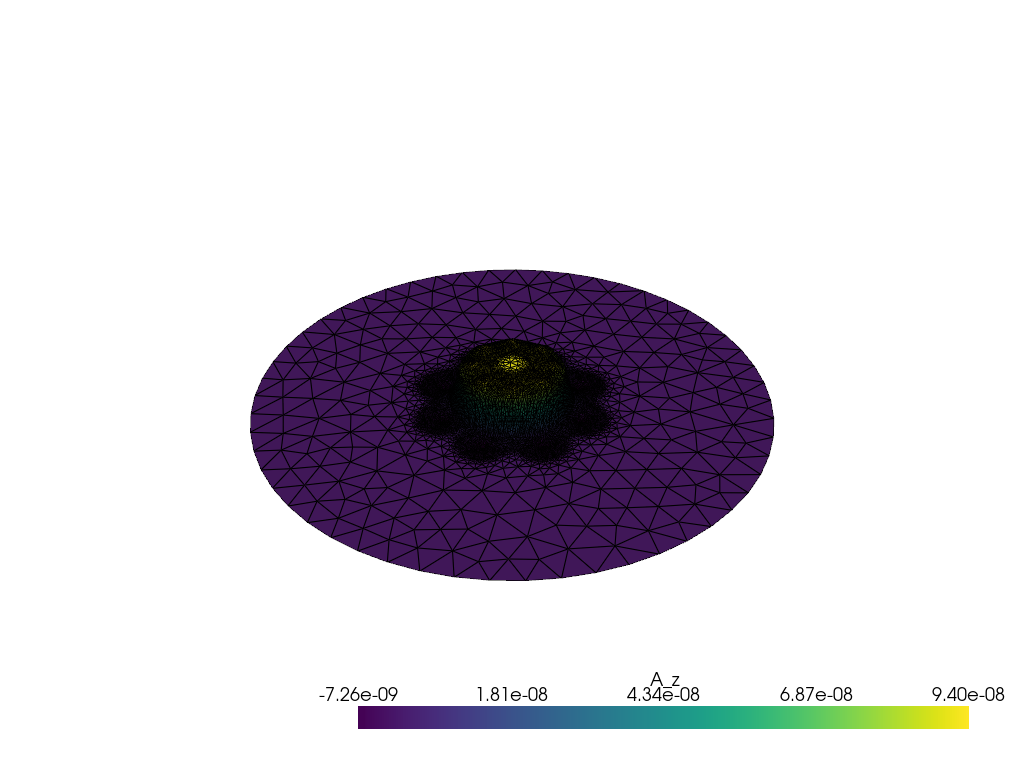

In [10]:
plotter = pyvista.Plotter()

Az_grid = pyvista.UnstructuredGrid(*vtk_mesh(V))
Az_grid.point_data["A_z"] = A_z.x.array
Az_grid.set_active_scalars("A_z")
warp = Az_grid.warp_by_scalar("A_z", factor=1e7)
actor = plotter.add_mesh(warp, show_edges=True)
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    Az_fig = plotter.screenshot("Az.png")

## Visualizing the magnetic field
As the magnetic field is a piecewise constant vector field, we need create a custom plotting function.
We start by computing the midpoints of each cell, which is where we would like to visualize the cell-wise constant vector.
Next, we take the data from the function `B`, and  shape it to become a 3D vector.
We connect the vector field with the midpoint by using `pyvista.PolyData`.

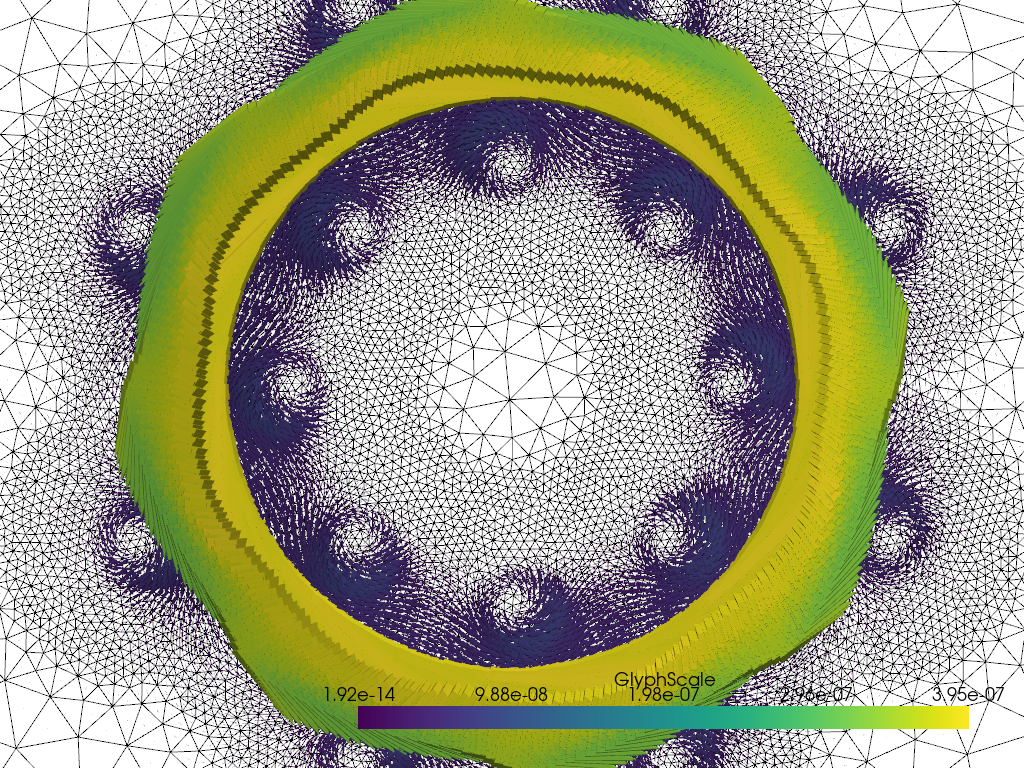

In [11]:
plotter = pyvista.Plotter()
plotter.set_position([0, 0, 5])

# We include ghosts cells as we access all degrees of freedom (including ghosts) on each process
top_imap = mesh.topology.index_map(mesh.topology.dim)
num_cells = top_imap.size_local + top_imap.num_ghosts
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
midpoints = compute_midpoints(mesh, mesh.topology.dim, np.arange(num_cells, dtype=np.int32))

num_dofs = W.dofmap.index_map.size_local + W.dofmap.index_map.num_ghosts
assert (num_cells == num_dofs)
values = np.zeros((num_dofs, 3), dtype=np.float64)
values[:, :mesh.geometry.dim] = B.x.array.real.reshape(num_dofs, W.dofmap.index_map_bs)
cloud = pyvista.PolyData(midpoints)
cloud["B"] = values
glyphs = cloud.glyph("B", factor=2e6)
actor = plotter.add_mesh(grid, style="wireframe", color="k")
actor2 = plotter.add_mesh(glyphs)

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    B_fig = plotter.screenshot("B.png")